In [ ]:
!git clone https://github.com/facebookresearch/ImageBind
%cd ImageBind
!pip install .

from imagebind import data
import torch
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType


Cloning into 'ImageBind'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 146 (delta 60), reused 39 (delta 39), pack-reused 58 (from 1)
Receiving objects: 100% (146/146), 2.64 MiB | 19.07 MiB/s, done.
Resolving deltas: 100% (68/68), done.
/content/ImageBind
Processing /content/ImageBind
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/facebookresearch/pytorchvideo.git (to revision 28fe037d212663c6a24f373b94cc5d478c8c1a1d) to /tmp/pip-install-yxzbo8pu/pytorchvideo_90226c0a7c774a059523c9e6bcacaa39
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorchvideo.git /tmp/pip-install-yxzbo8pu/pytorchvideo_90226c0a7c774a059523c9e6bcacaa39
  Running command git rev-parse -q --verify 'sha^28fe037d212663c6a24f373b94cc5d478c8c1a1d'
  Running command git fetch -q https://github.com/facebookresearch/pytorchvideo.git 28fe037d212663c6a24f

ModuleNotFoundError: No module named 'pytorchvideo'

In [ ]:
!pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached fvcore-0.1.5.post20221221-py3-none-any.whl
  Using cached av-13.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.4 kB)
  Using cached parameterized-0.9.0-py2.py3-none-any.whl.metadata (18 kB)
  Using cached iopath-0.1.10-py3-none-any.whl
  Using cached yacs-0.1.8-py3-none-any.whl.metadata (639 bytes)
  Using cached portalocker-3.0.0-py3-none-any.whl.metadata (8.5 kB)
Using cached av-13.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (33.1 MB)
Using cached parameterized-0.9.0-py2.py3-none-any.whl (20 kB)
Using cached yacs-0.1.8-py3-none-any.whl (14 kB)
Using cached portalocker-3.0.0-py3-none-any.whl (19 kB)
  Created wheel for pytorchvideo: filename=pytorchvideo-0.1.5-py3-none-any.whl size=188685 sha256=d2a6f001bef99f5ba15b8872d47a2030b77f9479ff5bae7bc7f719ee51b1c9bb
  Stored in directory: /root/.cache/pip/whee

In [ ]:
import numpy as np

def get_row_diagonal_accuracy(confusion_matrix):
    """
    Calculate the percentage of rows where the diagonal element is the highest value.

    Parameters:
    confusion_matrix : array-like
        A square confusion matrix where rows represent actual classes
        and columns represent predicted classes

    Returns:
    float: Percentage (0-1) of rows where diagonal element is highest
    """
    # Convert input to numpy array if it isn't already
    conf_matrix = np.array(confusion_matrix)

    # Verify it's a square matrix
    if conf_matrix.shape[0] != conf_matrix.shape[1]:
        raise ValueError("Confusion matrix must be square")

    correct_rows = 0
    total_rows = conf_matrix.shape[0]

    # For each row, check if diagonal element is the maximum
    for i in range(total_rows):
        if conf_matrix[i, i] >= np.max(conf_matrix[i]):  # >= handles case where diagonal equals another value
            correct_rows += 1

    return correct_rows / total_rows

def load_descriptions():
  """
  Load descriptions from descriptions.txt into a list where the index matches the description.

  Returns:
      list: List of descriptions where index i contains the description for item i
  """
  descriptions = []
  with open("/content/descriptions.txt", "r") as f:
      for line in f:
          idx, desc = line.strip().split(',', 1)
          # Make sure list is long enough
          while len(descriptions) <= int(idx):
              descriptions.append(None)
          descriptions[int(idx)] = desc
  return descriptions

def generate_uniform_hypersphere(m, n):
    """
    Generate m points uniformly distributed on an n-dimensional unit hypersphere.

    This implementation uses the fact that normalizing vectors sampled from a
    multivariate normal distribution results in uniform distribution on the sphere.

    Parameters:
    m (int): Number of vectors to generate
    n (int): Dimension of the space

    Returns:
    numpy.ndarray: Array of shape (m, n) containing m n-dimensional unit vectors
    """
    # Generate random vectors from standard normal distribution
    vectors = np.random.normal(0, 1, (m, n))

    # Normalize each vector to lie on unit hypersphere
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    uniform_vectors = vectors / norms

    return torch.tensor(uniform_vectors)

Found 772 valid pairs, using 25


In [ ]:
text_list

['Engine starting',
 'Jingle (music)',
 'Singing',
 'Firecracker',
 'Effects unit',
 'Vehicle',
 'Music',
 'Video game music',
 'Fire alarm',
 'Musical instrument',
 'Clatter',
 'Music',
 'Female singing',
 'Run',
 'Jingle (music)',
 'Radio',
 'Music',
 'Music',
 'Narration, monologue',
 'Music',
 'Car',
 'Music',
 'Guitar',
 'Speech',
 'Vehicle']

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Instantiate model
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)




  0%|          | 0.00/4.47G [00:00<?, ?B/s]

ImageBindModel(
  (modality_preprocessors): ModuleDict(
    (vision): RGBDTPreprocessor(
      (cls_token): tensor((1, 1, 1280), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Sequential(
          (0): PadIm2Video()
          (1): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
      )
      (pos_embedding_helper): SpatioTemporalPosEmbeddingHelper(
        (pos_embed): tensor((1, 257, 1280), requires_grad=True)
        
      )
    )
    (text): TextPreprocessor(
      (pos_embed): tensor((1, 77, 1024), requires_grad=True)
      (mask): tensor((77, 77), requires_grad=False)
      
      (token_embedding): Embedding(49408, 1024)
    )
    (audio): AudioPreprocessor(
      (cls_token): tensor((1, 1, 768), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10), bias=False)
        (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=

In [ ]:
import numpy as np
import os

def create_test_set():
  """
  Test set should be created with corresponding image/audio pairs in /content/{image,audio}_i.{jpg,wav}.

  Intermediate language descriptions for PHI_B should be found at /content/descriptions.txt
  """
  descriptions = load_descriptions()

  # Find which indices actually have both image and audio files
  valid_indices = []
  for i in range(len(descriptions)):
      image_path = f'/content/image_{i}.jpg'
      audio_path = f'/content/audio_{i}.wav'
      if os.path.exists(image_path) and os.path.exists(audio_path):
          valid_indices.append(i)

  # Shuffle the valid indices
  shuffled_valid_indices = np.random.permutation(valid_indices)

  # Take only N items (or all if less than N available)
  N = 25
  n_available = min(N, len(shuffled_valid_indices))
  selected_indices = shuffled_valid_indices[:n_available]

  # Create the path lists using only valid indices
  image_paths = [f'/content/image_{i}.jpg' for i in selected_indices]
  audio_paths = [f'/content/audio_{i}.wav' for i in selected_indices]
  text_list = [descriptions[i] for i in selected_indices]

  print(f"Found {len(valid_indices)} valid pairs, using {n_available}")

  return image_paths, audio_paths, text_list

image_paths, audio_paths, text_list = create_test_set()

Found 772 valid pairs, using 25
['Speech', 'Zither', 'Boat, Water vehicle', 'Speech', 'Speech', 'Musical instrument', 'Musical instrument', 'Sound effect', 'Vibration', 'Jazz', 'Fly, housefly', 'Male singing', 'Inside, small room', 'Speech', 'Vehicle', 'Music', 'Babbling', 'Musical instrument', 'Speech', 'Lawn mower', 'Electronic music', 'Narration, monologue', 'Speech', 'Plucked string instrument', 'Strum']


In [ ]:
import time
import torch
import os

def run_timing_test():
    # Time file existence check
    start_time = time.time()
    valid_indices = []
    for i in range(1):
        image_path = f'/content/image_{i}.jpg'
        if os.path.exists(image_path):
            valid_indices.append(i)
    file_check_time = time.time() - start_time

    # Time path list creation
    start_time = time.time()
    image_paths = [f'/content/image_{i}.jpg' for i in valid_indices]
    path_creation_time = time.time() - start_time

    # Time data loading and model inference
    start_time = time.time()
    inputs = {
        ModalityType.VISION: data.load_and_transform_vision_data(image_paths, device),
    }
    data_load_time = time.time() - start_time

    # Time model inference
    start_time = time.time()
    with torch.no_grad():
        embeddings = model(inputs)
    inference_time = time.time() - start_time

    # Print results
    print(f"File existence check time: {file_check_time:.3f} seconds")
    print(f"Path list creation time: {path_creation_time:.3f} seconds")
    print(f"Data loading time: {data_load_time:.3f} seconds")
    print(f"Model inference time: {inference_time:.3f} seconds")
    print(f"Total time: {file_check_time + path_creation_time + data_load_time + inference_time:.3f} seconds")
    print(f"Number of valid images: {len(valid_indices)}")

# Run the test
run_timing_test()

File existence check time: 0.000 seconds
Path list creation time: 0.000 seconds
Data loading time: 0.016 seconds
Model inference time: 0.071 seconds
Total time: 0.087 seconds
Number of valid images: 1


In [ ]:
import time
import torch
import os

def time_dot_product(n_repeats=1000):
    # Create two random 512-dim vectors
    v1 = torch.randn(512, device=device)
    v2 = torch.randn(512, device=device)

    # Time dot product
    start_time = time.time()
    for _ in range(n_repeats):
        with torch.no_grad():
            dot = torch.dot(v1, v2)
    dot_time = (time.time() - start_time) / n_repeats

    print(f"Average dot product time: {dot_time*1000:.3f} milliseconds")  # Convert to ms
    print(f"Average dot product time: {dot_time*1_000_000:.3f} microseconds")  # Convert to μs
    return dot_time

def run_timing_test():
    # Time file existence check
    start_time = time.time()
    valid_indices = []
    for i in range(1):
        image_path = f'/content/image_{i}.jpg'
        if os.path.exists(image_path):
            valid_indices.append(i)
    file_check_time = time.time() - start_time

    # Time path list creation
    start_time = time.time()
    image_paths = [f'/content/image_{i}.jpg' for i in valid_indices]
    path_creation_time = time.time() - start_time

    # Time data loading and model inference
    start_time = time.time()
    inputs = {
        ModalityType.VISION: data.load_and_transform_vision_data(image_paths, device),
    }
    data_load_time = time.time() - start_time

    # Time model inference
    start_time = time.time()
    with torch.no_grad():
        embeddings = model(inputs)
    inference_time = time.time() - start_time

    # Print results
    print("\nMain Pipeline Timing:")
    print(f"File existence check time: {file_check_time:.3f} seconds")
    print(f"Path list creation time: {path_creation_time:.3f} seconds")
    print(f"Data loading time: {data_load_time:.3f} seconds")
    print(f"Model inference time: {inference_time:.3f} seconds")
    print(f"Total time: {file_check_time + path_creation_time + data_load_time + inference_time:.3f} seconds")
    print(f"Number of valid images: {len(valid_indices)}")

print("Timing dot product...")
dot_time = time_dot_product()
print("\nRunning main pipeline timing...")
run_timing_test()

Timing dot product...
Average dot product time: 0.015 milliseconds
Average dot product time: 15.177 microseconds

Running main pipeline timing...

Main Pipeline Timing:
File existence check time: 0.000 seconds
Path list creation time: 0.000 seconds
Data loading time: 0.035 seconds
Model inference time: 0.023 seconds
Total time: 0.058 seconds
Number of valid images: 1


In [ ]:

def get_embeddings(image_paths, audio_paths, text_list):
  # Load data
  inputs = {
      ModalityType.TEXT: data.load_and_transform_text(text_list, device),
      ModalityType.VISION: data.load_and_transform_vision_data(image_paths, device),
      ModalityType.AUDIO: data.load_and_transform_audio_data(audio_paths, device),
  }

  with torch.no_grad():
      embeddings = model(inputs)

  return embeddings

embeddings = get_embeddings(image_paths, audio_paths, text_list)

NameError: name 'image_paths' is not defined

torch.Size([25, 1024])
torch.Size([25, 1024])
Accuracy for M = 100: 0.08


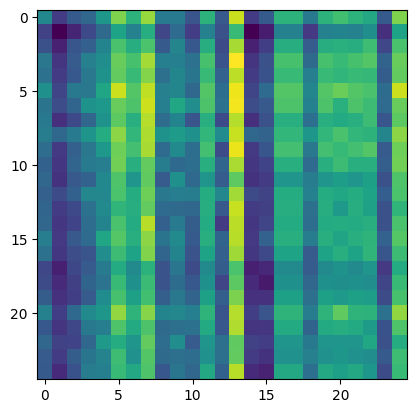

Accuracy for M = 500: 0.08


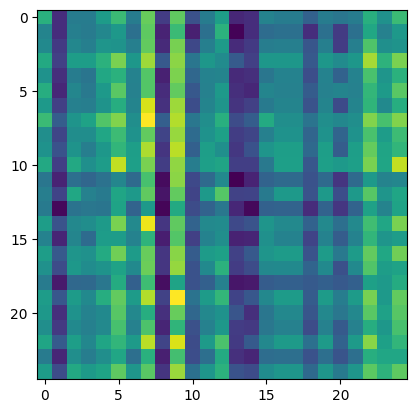

Accuracy for M = 1000: 0.08


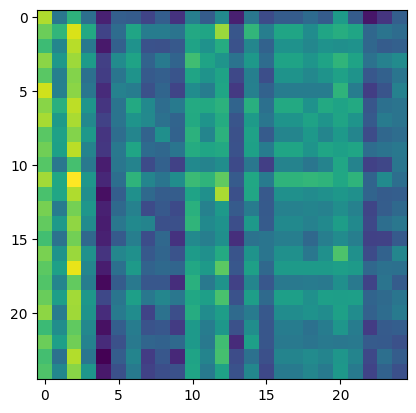

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

embeddings_A = embeddings[ModalityType.AUDIO].cpu()
embeddings_C = embeddings[ModalityType.TEXT].cpu()

print(embeddings_A.shape)
print(embeddings_C.shape)

# plt.imshow(grid)
# plt.show()

mc_sizes = [100, 500, 1000, 2500, 5000]
tau = 5

for M in mc_sizes:
  PHI_B = generate_uniform_hypersphere(M, embeddings_A.shape[1])

  grid_lse = np.zeros(grid.shape)
  for i in range(embeddings_A.shape[0]):
    for j in range(embeddings_C.shape[0]):
      for phi in PHI_B:
        grid_lse[i, j] += torch.exp(embeddings_A[i] @ phi.T.float() / tau + phi.float() @ embeddings_C[j].T / tau).detach().cpu().numpy()

  acc_lse = get_row_diagonal_accuracy(grid_lse)
  print(f'Accuracy for M = {M}: {acc_lse}')
  plt.imshow(grid_lse)
  plt.show()

Reference accuracy: 0.3200
Accuracy for M = 1: 0.0400
Accuracy for M = 2: 0.0400
Accuracy for M = 4: 0.0400
Accuracy for M = 8: 0.0400
Accuracy for M = 16: 0.0400
Accuracy for M = 32: 0.0800
Accuracy for M = 64: 0.0800
Accuracy for M = 128: 0.0400
Accuracy for M = 256: 0.0800
Accuracy for M = 512: 0.0400
Accuracy for M = 1024: 0.0400
Accuracy for M = 2048: 0.0400
Accuracy for M = 4096: 0.1600
Accuracy for M = 8192: 0.0800
Accuracy for M = 16384: 0.3200
Accuracy for M = 32768: 0.2800
Accuracy for M = 65536: 0.2800


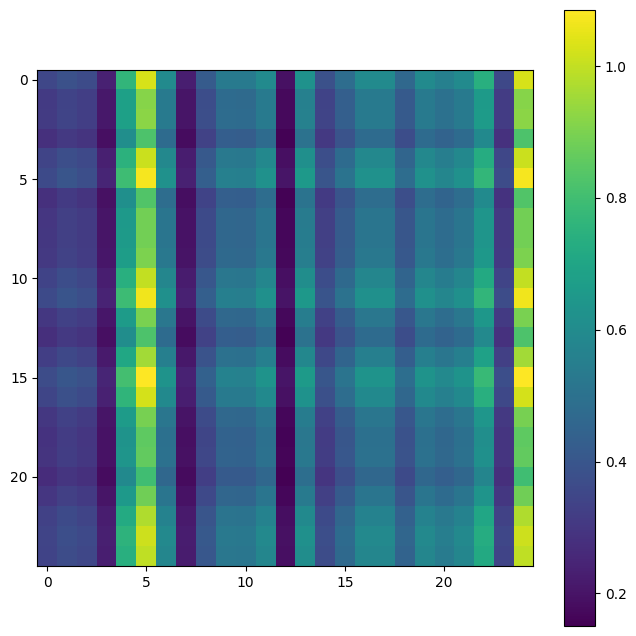

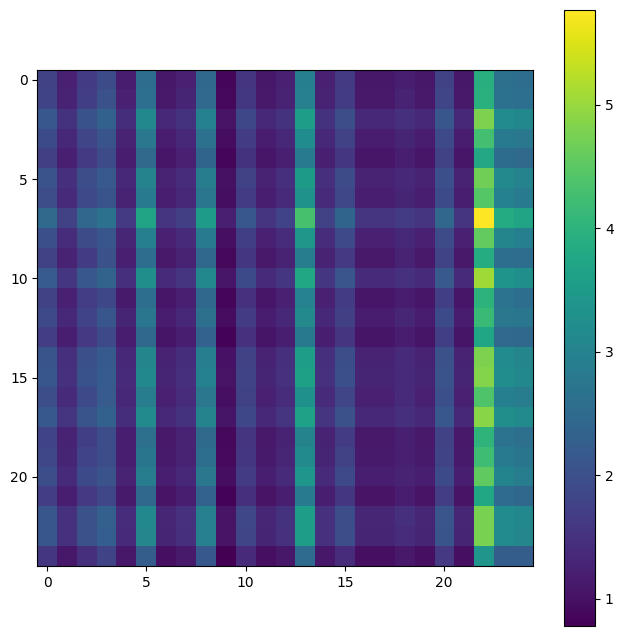

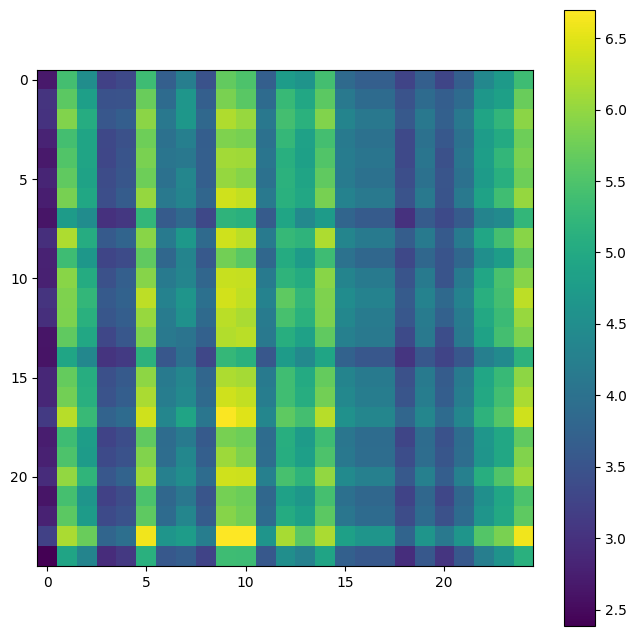

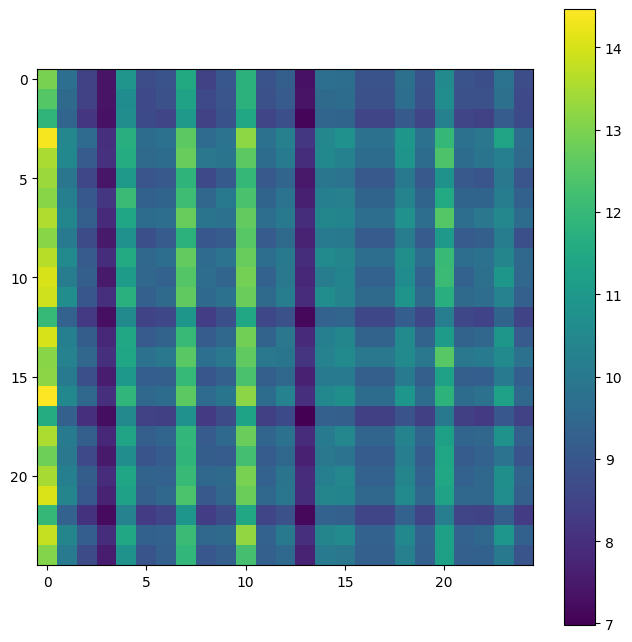

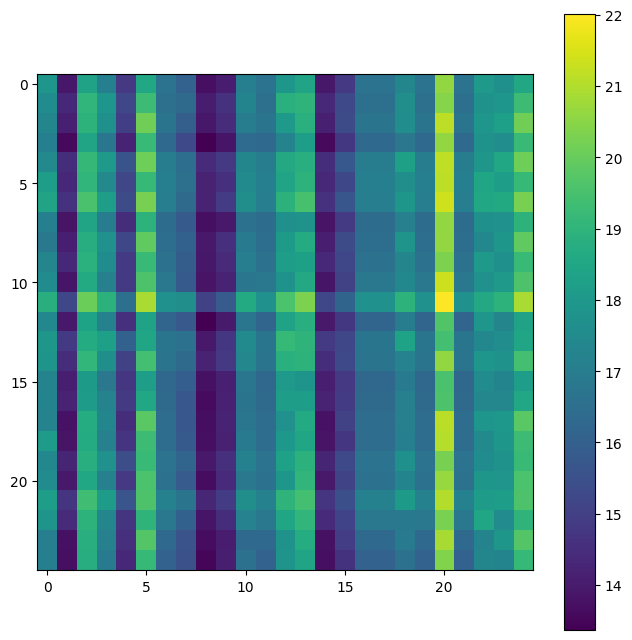

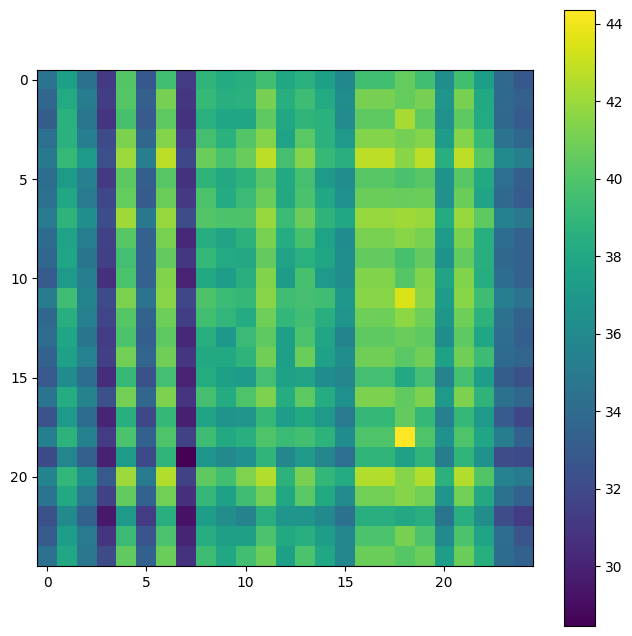

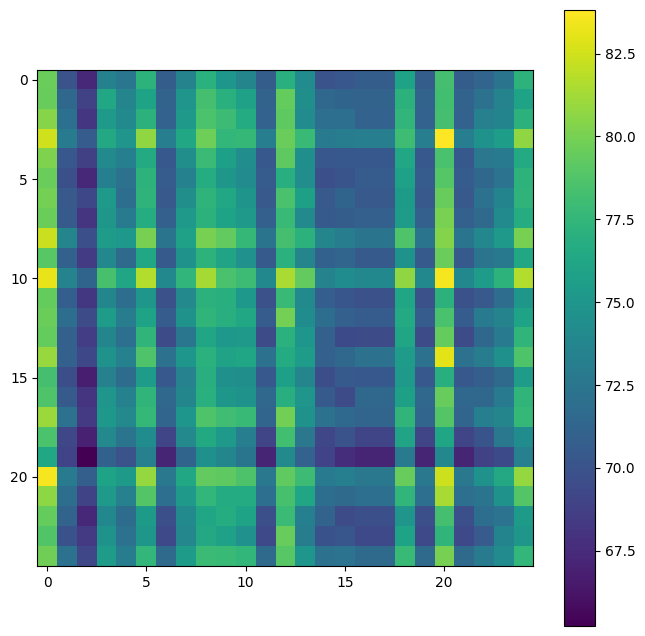

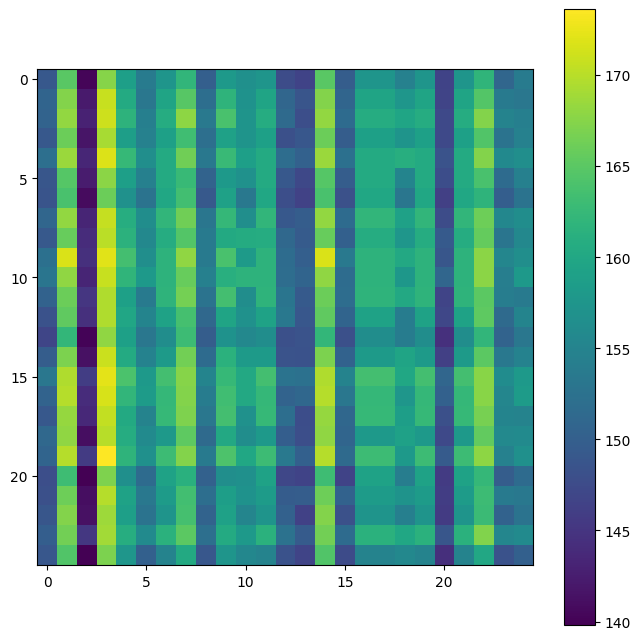

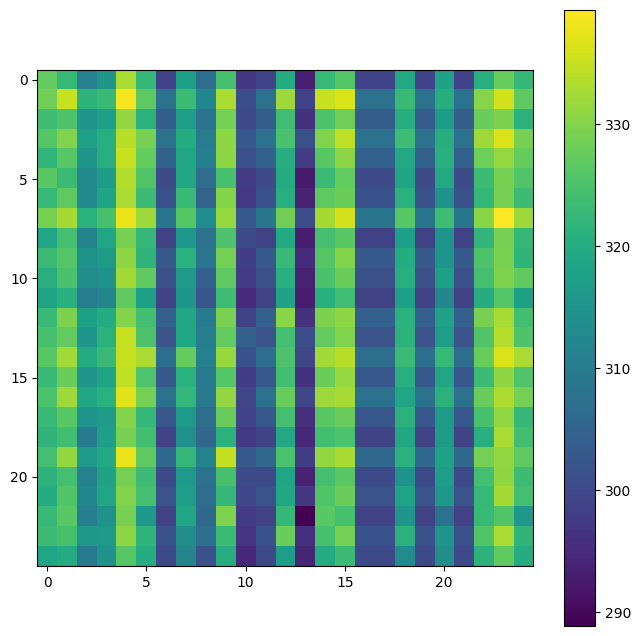

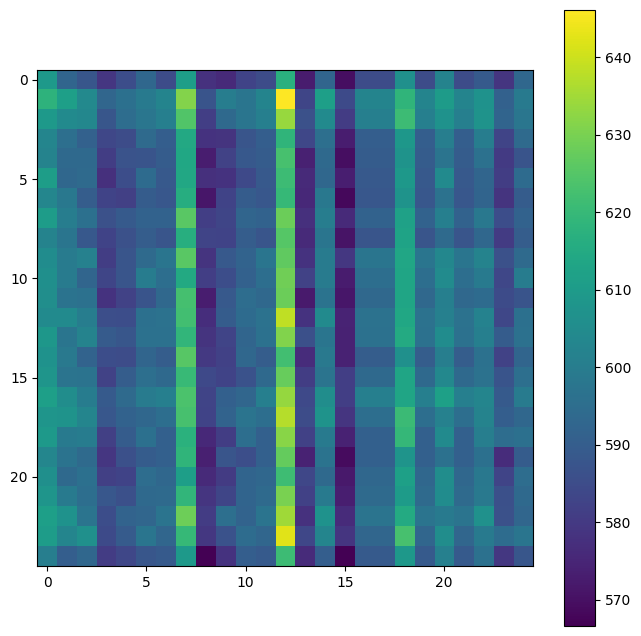

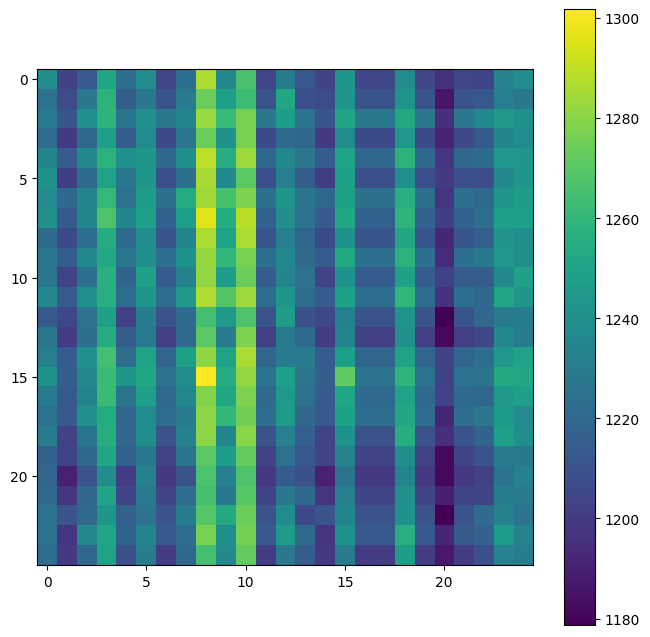

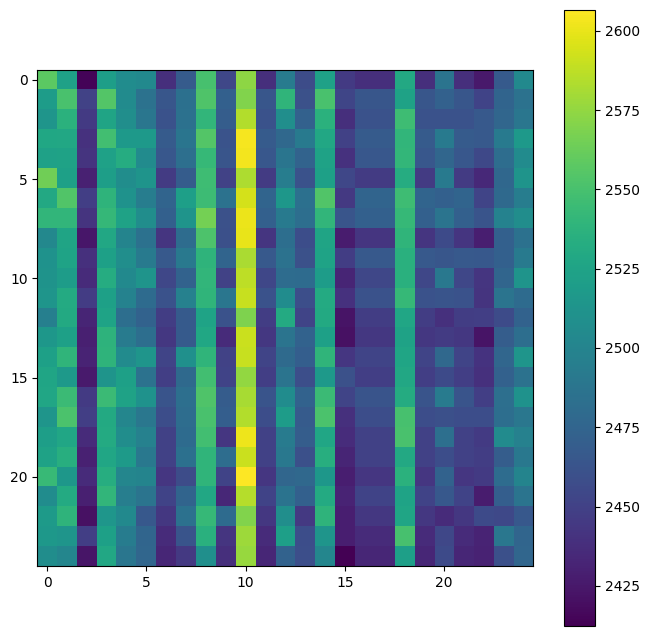

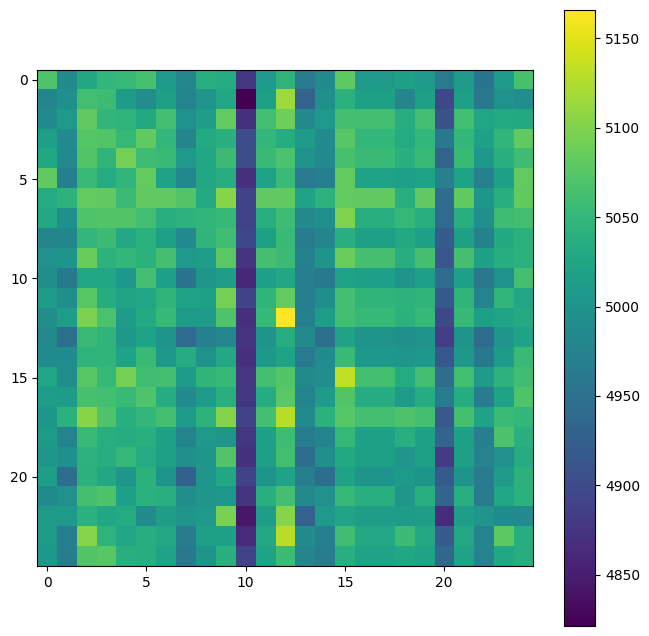

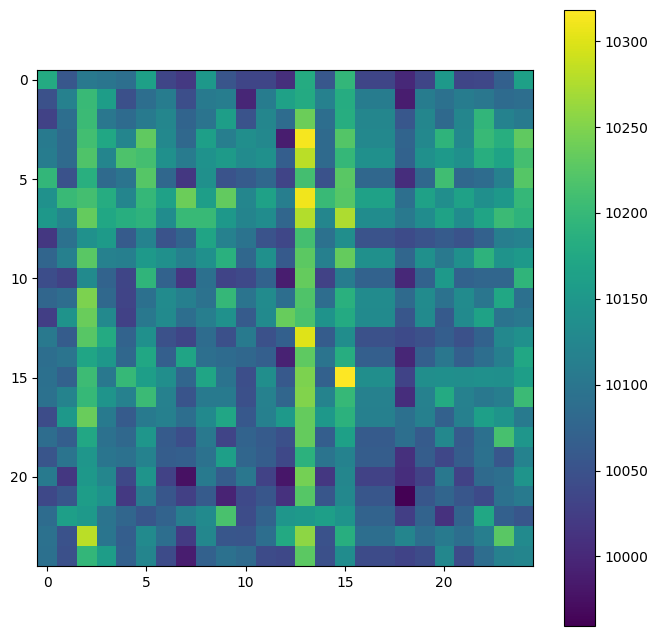

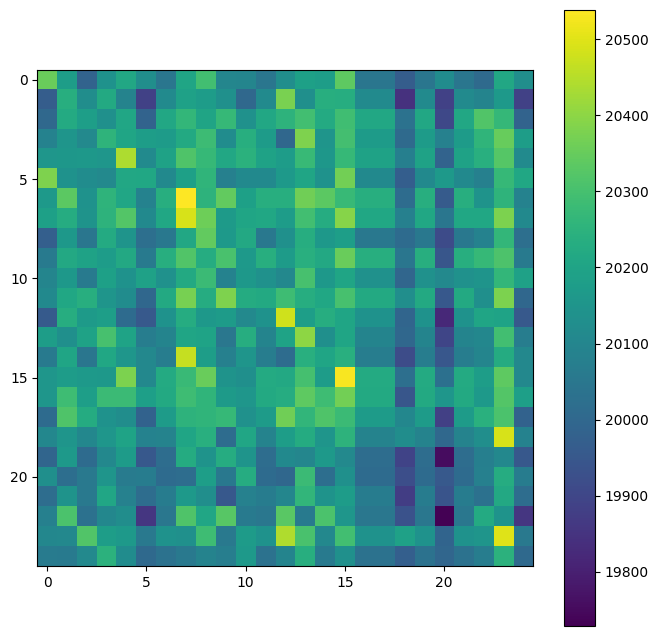

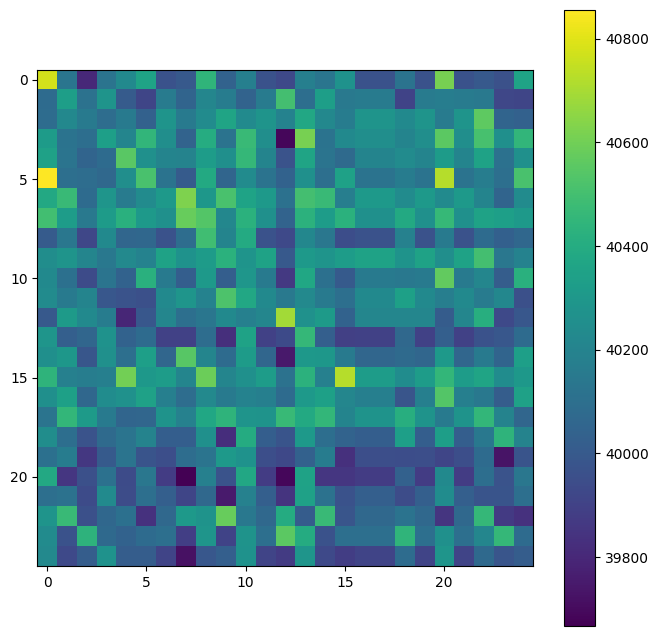

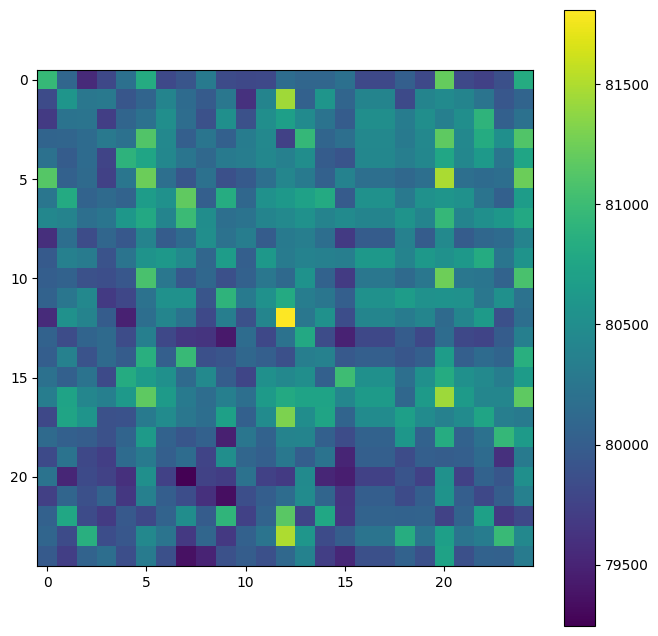

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import softmax

def generate_uniform_hypersphere(M, dim):
    """Generate points on unit hypersphere more efficiently"""
    # Generate random normal vectors
    vectors = torch.randn(M, dim)
    # Normalize to unit length
    return vectors / torch.norm(vectors, dim=1, keepdim=True)

def compute_grid_lse_batched(embeddings_A, embeddings_C, PHI_B, tau=5, batch_size=100):
    """
    Compute LSE grid using batched operations on GPU
    """
    M = PHI_B.shape[0]
    N_A = embeddings_A.shape[0]
    N_C = embeddings_C.shape[0]
    device = embeddings_A.device

    # Move PHI_B to GPU if not already there
    PHI_B = PHI_B.to(device)

    # Initialize output grid on GPU
    grid_lse = torch.zeros((N_A, N_C), device=device)

    # Process in batches of PHI_B to manage memory
    for phi_start in range(0, M, batch_size):
        phi_end = min(phi_start + batch_size, M)
        phi_batch = PHI_B[phi_start:phi_end]

        # Compute first term: embeddings_A @ phi.T
        term1 = embeddings_A @ phi_batch.T  # [N_A, batch_size]

        # Compute second term: phi @ embeddings_C.T
        term2 = phi_batch @ embeddings_C.T  # [batch_size, N_C]

        # Broadcasting will handle the addition
        # [N_A, batch_size, 1] + [batch_size, N_C] -> [N_A, batch_size, N_C]
        combined = (term1.unsqueeze(-1) + term2.unsqueeze(0)) / tau

        # Sum the exponentials for this batch
        grid_lse += torch.exp(combined).sum(dim=1)

    return grid_lse.detach()

def get_row_diagonal_accuracy(grid):
    """Calculate accuracy from grid"""
    predictions = torch.argmax(grid, dim=1)
    correct = (predictions == torch.arange(len(predictions), device=predictions.device))
    return correct.float().mean().item()

# Main execution
def run_mc_analysis(embeddings_A, embeddings_C, mc_sizes, tau=5):
    """Run Monte Carlo analysis for different sample sizes"""
    device = embeddings_A.device
    results = []
    grids = []

    # Compute reference grid
    ref_grid = torch.softmax(embeddings_A @ embeddings_C.T, dim=-1)
    ref_acc = get_row_diagonal_accuracy(ref_grid)
    print(f'Reference accuracy: {ref_acc:.4f}')

    for M in mc_sizes:
        # Generate points on hypersphere (on CPU to save GPU memory)
        PHI_B = generate_uniform_hypersphere(M, embeddings_A.shape[1])

        # Compute LSE grid
        grid_lse = compute_grid_lse_batched(embeddings_A, embeddings_C, PHI_B, tau)

        # Calculate accuracy
        acc_lse = get_row_diagonal_accuracy(grid_lse)
        results.append(acc_lse)
        grids.append(grid_lse.cpu().numpy())

        print(f'Accuracy for M = {M}: {acc_lse:.4f}')

    return results, grids

# Example usage:
mc_sizes = [2**i for i in range(17)]
results, grids = run_mc_analysis(embeddings_A, embeddings_C, mc_sizes, tau=5)

# Plot results
for grid in grids:
    plt.figure(figsize=(8, 8))
    plt.imshow(grid)
    plt.colorbar()
    plt.show()

Reference accuracy: 0.3200
Accuracy for M = 1: 0.0400
Accuracy for M = 2: 0.0400
Accuracy for M = 4: 0.0400
Accuracy for M = 8: 0.0400
Accuracy for M = 16: 0.0800
Accuracy for M = 32: 0.0400
Accuracy for M = 64: 0.0400
Accuracy for M = 128: 0.0400
Accuracy for M = 256: 0.0400
Accuracy for M = 512: 0.0800
Accuracy for M = 1024: 0.0400
Accuracy for M = 2048: 0.0400
Accuracy for M = 4096: 0.0800
Accuracy for M = 8192: 0.0800
Accuracy for M = 16384: 0.2800
Accuracy for M = 32768: 0.2400
Accuracy for M = 65536: 0.2400
Accuracy for M = 131072: 0.2800


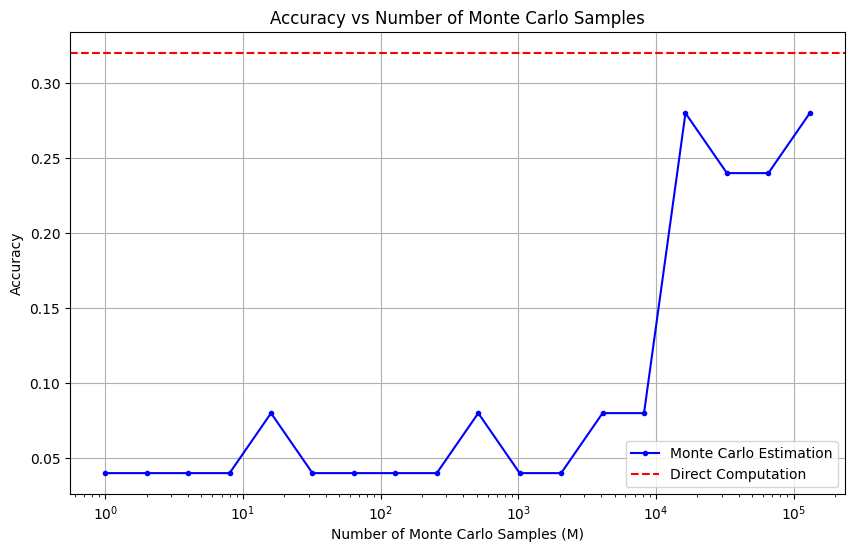

In [ ]:
# After running the analysis
mc_sizes = [2**i for i in range(18)]
results, grids = run_mc_analysis(embeddings_A, embeddings_C, mc_sizes, tau=5)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot MC results
plt.semilogx(mc_sizes, results, 'b.-', label='Monte Carlo Estimation')

# Add reference accuracy line
ref_acc = get_row_diagonal_accuracy(torch.softmax(embeddings_A @ embeddings_C.T, dim=-1))
plt.axhline(y=ref_acc, color='r', linestyle='--', label='Direct Computation')

# Customize the plot
plt.grid(True)
plt.xlabel('Number of Monte Carlo Samples (M)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Monte Carlo Samples')
plt.legend()

# Show the plot
plt.show()

Found 772 valid pairs, using 25
Reference accuracy: 0.1200
Accuracy for M = 1: 0.0400
Accuracy for M = 2: 0.0400
Accuracy for M = 4: 0.0400
Accuracy for M = 8: 0.0400
Accuracy for M = 16: 0.0800
Accuracy for M = 32: 0.0800
Accuracy for M = 64: 0.0000
Accuracy for M = 128: 0.0800
Accuracy for M = 256: 0.0800
Accuracy for M = 512: 0.1200
Accuracy for M = 1024: 0.0400
Accuracy for M = 2048: 0.1600
Accuracy for M = 4096: 0.1200
Accuracy for M = 8192: 0.1200
Accuracy for M = 16384: 0.1600
Accuracy for M = 32768: 0.0800
Accuracy for M = 65536: 0.1600
Accuracy for M = 131072: 0.1600


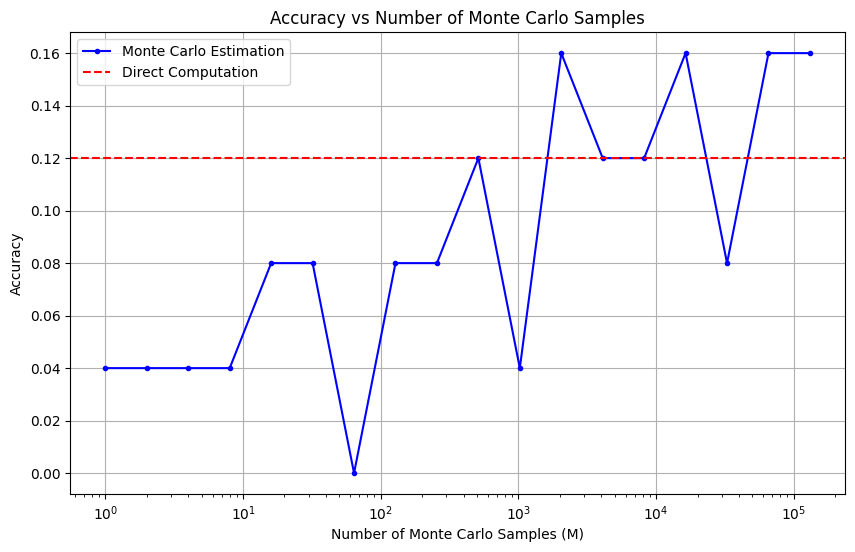

In [ ]:
NUM_TRIALS = 5

for i in range(NUM_TRIALS)
  image_paths, audio_paths, text_list = create_test_set()
  embeddings = get_embeddings(image_paths, audio_paths, text_list)

  embeddings_A = embeddings[ModalityType.AUDIO].cpu()
  embeddings_C = embeddings[ModalityType.TEXT].cpu()

  # After running the analysis
  mc_sizes = [2**i for i in range(18)]
  results, grids = run_mc_analysis(embeddings_A, embeddings_C, mc_sizes, tau=5)

  # Create the plot
  plt.figure(figsize=(10, 6))

  # Plot MC results
  plt.semilogx(mc_sizes, results, 'b.-', label='Monte Carlo Estimation')

  # Add reference accuracy line
  ref_acc = get_row_diagonal_accuracy(torch.softmax(embeddings_A @ embeddings_C.T, dim=-1))
  plt.axhline(y=ref_acc, color='r', linestyle='--', label='Direct Computation')

  # Customize the plot
  plt.grid(True)
  plt.xlabel('Number of Monte Carlo Samples (M)')
  plt.ylabel('Accuracy')
  plt.title('Accuracy vs Number of Monte Carlo Samples')
  plt.legend()

  # Show the plot
  plt.show()

In [ ]:
import numpy as np
from scipy import stats

NUM_TRIALS = 50
mc_sizes = [2**i for i in range(20)]

# Arrays to store results
all_results = np.zeros((NUM_TRIALS, len(mc_sizes)))
all_refs = np.zeros(NUM_TRIALS)

# Run trials
for i in range(NUM_TRIALS):
    print(f"Running trial {i+1}/{NUM_TRIALS}")

    # Get new dataset
    image_paths, audio_paths, text_list = create_test_set()
    embeddings = get_embeddings(image_paths, audio_paths, text_list)

    embeddings_A = embeddings[ModalityType.AUDIO].cpu()
    embeddings_C = embeddings[ModalityType.TEXT].cpu()

    # Run analysis
    results, _ = run_mc_analysis(embeddings_A, embeddings_C, mc_sizes, tau=5)
    ref_acc = get_row_diagonal_accuracy(torch.softmax(embeddings_A @ embeddings_C.T, dim=-1))

    # Store results
    all_results[i] = results
    all_refs[i] = ref_acc



Running trial 1/50
Found 772 valid pairs, using 25
Reference accuracy: 0.2800
Accuracy for M = 1: 0.0400
Accuracy for M = 2: 0.0400
Accuracy for M = 4: 0.0800
Accuracy for M = 8: 0.0400
Accuracy for M = 16: 0.0400
Accuracy for M = 32: 0.0400
Accuracy for M = 64: 0.0400
Accuracy for M = 128: 0.0000
Accuracy for M = 256: 0.0800
Accuracy for M = 512: 0.0400
Accuracy for M = 1024: 0.0400
Accuracy for M = 2048: 0.1200
Accuracy for M = 4096: 0.0800
Accuracy for M = 8192: 0.1200
Accuracy for M = 16384: 0.2000
Accuracy for M = 32768: 0.2000
Accuracy for M = 65536: 0.2400
Accuracy for M = 131072: 0.2800
Accuracy for M = 262144: 0.2800
Accuracy for M = 524288: 0.2400
Running trial 2/50
Found 772 valid pairs, using 25
Reference accuracy: 0.3200
Accuracy for M = 1: 0.0400
Accuracy for M = 2: 0.0400
Accuracy for M = 4: 0.0400
Accuracy for M = 8: 0.0400
Accuracy for M = 16: 0.0400
Accuracy for M = 32: 0.0400
Accuracy for M = 64: 0.0400
Accuracy for M = 128: 0.1200
Accuracy for M = 256: 0.0400
Accura

Reference accuracy: 0.3200
Accuracy for M = 1: 0.0400
Accuracy for M = 2: 0.0400
Accuracy for M = 4: 0.0800
Accuracy for M = 8: 0.0400
Accuracy for M = 16: 0.0400
Accuracy for M = 32: 0.0400
Accuracy for M = 64: 0.0400
Accuracy for M = 128: 0.0400
Accuracy for M = 256: 0.0400
Accuracy for M = 512: 0.0400
Accuracy for M = 1024: 0.0400
Accuracy for M = 2048: 0.0400
Accuracy for M = 4096: 0.0800
Accuracy for M = 8192: 0.1200
Accuracy for M = 16384: 0.1600
Accuracy for M = 32768: 0.2400
Accuracy for M = 65536: 0.1600
Accuracy for M = 131072: 0.2400
Accuracy for M = 262144: 0.2400
Accuracy for M = 524288: 0.2400
Running trial 46/50
Found 772 valid pairs, using 25
Reference accuracy: 0.2400
Accuracy for M = 1: 0.0400
Accuracy for M = 2: 0.0400
Accuracy for M = 4: 0.0800
Accuracy for M = 8: 0.0400
Accuracy for M = 16: 0.0400
Accuracy for M = 32: 0.0400
Accuracy for M = 64: 0.1200
Accuracy for M = 128: 0.0800
Accuracy for M = 256: 0.0400
Accuracy for M = 512: 0.0000
Accuracy for M = 1024: 0.08


Mean reference accuracy: 0.2288 ± 0.0166
M=1: 0.0400 ± 0.0000
M=2: 0.0392 ± 0.0016
M=4: 0.0440 ± 0.0047
M=8: 0.0456 ± 0.0046
M=16: 0.0432 ± 0.0031
M=32: 0.0448 ± 0.0055
M=64: 0.0456 ± 0.0069
M=128: 0.0528 ± 0.0078
M=256: 0.0624 ± 0.0111
M=512: 0.0680 ± 0.0120
M=1024: 0.0760 ± 0.0126
M=2048: 0.1016 ± 0.0166
M=4096: 0.1192 ± 0.0142
M=8192: 0.1344 ± 0.0167
M=16384: 0.1680 ± 0.0157
M=32768: 0.2064 ± 0.0146
M=65536: 0.2048 ± 0.0179
M=131072: 0.2136 ± 0.0192
M=262144: 0.2232 ± 0.0170
M=524288: 0.2248 ± 0.0178


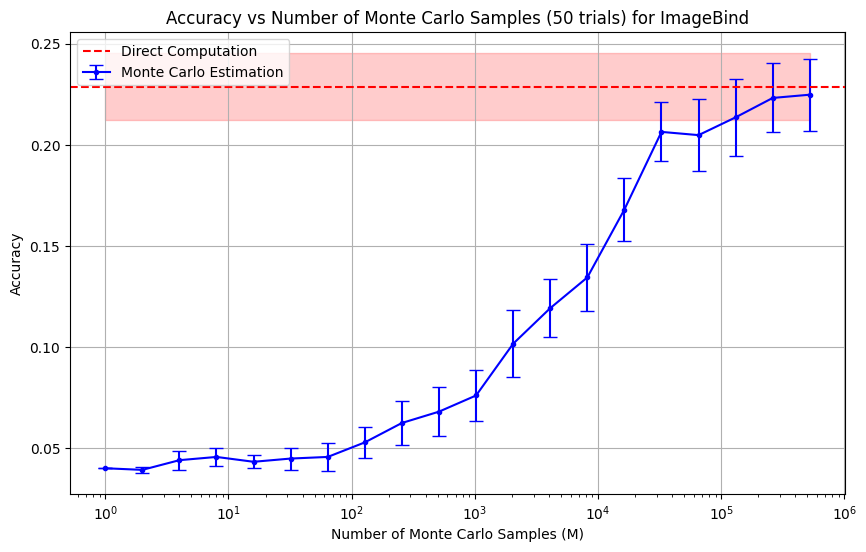

In [ ]:
# Calculate statistics
mean_results = np.mean(all_results, axis=0)
mean_ref = np.mean(all_refs)

# Calculate 95% confidence intervals
confidence_intervals = stats.sem(all_results, axis=0) * stats.t.ppf((1 + 0.95) / 2, NUM_TRIALS-1)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot MC results with error bars
plt.errorbar(mc_sizes, mean_results, yerr=confidence_intervals, fmt='b.-',
            label='Monte Carlo Estimation', capsize=5)

# Add reference accuracy line with shaded error region
ref_confidence = stats.sem(all_refs) * stats.t.ppf((1 + 0.95) / 2, NUM_TRIALS-1)
plt.axhline(y=mean_ref, color='r', linestyle='--', label='Direct Computation')
plt.fill_between(mc_sizes, mean_ref - ref_confidence, mean_ref + ref_confidence,
                color='r', alpha=0.2)

# Customize the plot
plt.grid(True)
plt.xscale('log')  # Using xscale instead of semilogx for compatibility with errorbar
plt.xlabel('Number of Monte Carlo Samples (M)')
plt.ylabel('Accuracy')
plt.title(f'Accuracy vs Number of Monte Carlo Samples ({NUM_TRIALS} trials) for ImageBind')
plt.legend()

# Print statistics
print(f"\nMean reference accuracy: {mean_ref:.4f} ± {ref_confidence:.4f}")
for size, mean, ci in zip(mc_sizes, mean_results, confidence_intervals):
    print(f"M={size}: {mean:.4f} ± {ci:.4f}")

plt.show()